In [79]:
# Setup imports
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from scipy.interpolate import make_interp_spline
import matplotlib.colors as mcolors

In [80]:
# Set rcParams for text size
plt.rcParams.update({
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'figure.figsize': [6, 3],
    'legend.fontsize': 18,
    'legend.columnspacing': 2,
    'legend.handletextpad': 0.5,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

In [81]:
# A function to read a log file for all lines containing a specific
# string. It should then create a list of tuples where each tuple is
# of the form (time_from_start_seconds, accuracy). String to find from
# the logfile is passed as an argument. It should return this list of
# tuples. It should also take the filename with path of the logfile
# as an argument.
def parse_log_file_ts_acc_values(filepath, search_string):
    result = []
    base_time = None

    with open(filepath, 'r') as file:
        for line in file:
            if not base_time:
                try:
                    # Attempt to extract the timestamp from the line
                    base_time = datetime.strptime(line.split(" | ")[0], "%Y-%m-%d %H:%M:%S,%f")
                except (ValueError, IndexError):
                    # Skip lines that don't have a valid timestamp
                    continue
            
            if search_string in line:
                parts = line.strip().split(" | ")
                timestamp = datetime.strptime(parts[0], "%Y-%m-%d %H:%M:%S,%f")
                time_from_start = (timestamp - base_time).total_seconds()
                
                # Extract the accuracy value from the last parenthesis
                accuracy_str = parts[-1].split("(")[-1].strip(")")
                accuracy = float(accuracy_str) * 100
                
                result.append((time_from_start, accuracy))
    
    return result

In [82]:
# Populate acc tuples from log files
log_file_dir = "/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/agg_logs"

# Synthetic unavail 0% logs
# Oracular syn 0 was accidentally run with 0 unavail. Run deleted from
# wandb but logs exist.
oort_syn0_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_sheph_14_05_12_52_alpha0.1_cifar_70acc_fedavg_oort_unaware_syn_50.log", ", test accuracy:"
)
oort_oracular_syn0_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_wash_11_05_02_42_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn0.log", ", test accuracy:"
)
oort_async_oracular_syn0_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_sheph_11_05_02_42_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn0.log", ", test accuracy:"
)
felix_syn0_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_sheph_13_05_01_50_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_0.log", ", test accuracy:"
)

In [83]:
# Synthetic unavail 10% logs
oort_syn10_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_wash_14_05_21_15_alpha0.1_cifar_70acc_fedavg_oort_unaware_syn_20.log", ", test accuracy:"
)
oort_oracular_syn10_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_wash_11_05_11_49_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn20.log", ", test accuracy:"
)
oort_async_oracular_syn10_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_jayne_11_05_15_20_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn20.log", ", test accuracy:"
)
felix_syn10_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_sheph_13_05_08_29_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_20.log", ", test accuracy:"
)

In [84]:
# Synthetic unavail 50% logs
oort_syn50_acc = None
oort_oracular_syn50_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_wash_11_05_20_20_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn50.log", ", test accuracy:"
)
oort_async_oracular_syn50_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_sheph_11_05_15_21_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn50.log", ", test accuracy:"
)
felix_syn50_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_jayne_13_05_01_52_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_50.log", ", test accuracy:"
)

In [85]:
# Mobiperf logs
oort_mobiperf_acc = None
oort_oracular_mobiperf_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_wash_12_05_05_41_alpha0.1_cifar_70acc_fedavg_oort_oracular_mobiperf.log", ", test accuracy:"
)
oort_async_oracular_mobiperf_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_jayne_12_05_00_04_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_mobiperf.log", ", test accuracy:"
)
felix_mobiperf_acc = parse_log_file_ts_acc_values(
    f"{log_file_dir}/agg_wash_13_05_01_51_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_mobiperf_3st.log", ", test accuracy:"
)

In [86]:
# Define colors and markers for different strategies. There are two
# types of strategies. SOTA and naive improvements over SOTA. The sota
# strategies should be solid lines and the naive improvements should
# be dashed lines. The sota strategies are oort, fedbuff and felix.
# The naive improvements are oort_async and oort_trace. The colors
# are defined in the color list. The markers are defined in the marker
# list. The colors and markers are used to plot the lines in the
# graph. The colors of naive improvements are the same as the sota
# strategies. The markers are different.

# Define colors and markers
colors = {
    'oort': '#009E73',         # burnt orange
    # 'fedbuff': 'maroon',      # teal green
    'felix': 'royalblue',        # mid blue (variant of blue, like RColorBrewer's 'Royal Blue')
    'oort_async': 'deeppink',   # purplish pink (stands out but elegant)
    'oort_trace': 'goldenrod'    # soft yellow
}

markers = {
    'oort': 'o',
    # 'fedbuff': 's',
    'felix': 'D',
    'oort_async': '^',
    'oort_trace': 'v'
}

line_styles = {
    'oort': 'solid',
    # 'fedbuff': 'solid',
    'felix': 'solid',
    'oort_async': 'solid',
    'oort_trace': 'solid'
}

strategy_labels = {
    'oort': 'OORT',
    # 'fedbuff': 'FedBuff',
    'felix': 'FeLiX',
    'oort_async': 'OORT+Async',
    'oort_trace': 'OORT-Trace'
}

In [87]:
# Function to plot accuracy vs time graph. Skip the legend. The
# function should take two main inputs: first is a list of lists that
# contain the timestamp and accuracy tuples. The second is a list of
# strategies corresponding to the lists. The function should plot the
# accuracy vs time graph for each strategy.

def plot_accuracy_vs_time(
    data_lists, 
    strategies, 
    smooth=True, 
    marker_interval=600, 
    smoothing_method='savgol',  # or 'moving_average'
    window_size=101, 
    polyorder=2,  # for Savitzky–Golay
    plot_markers=True,
    xlim_hours=10,  # New: extend or shrink x-axis in hours
    filename="temp.pdf"
):
    strategy_to_time_accuracy = {}

    for data, strategy in zip(data_lists, strategies):
        if data is None:
            # Plot constant 10% line across the time range
            times = np.linspace(0, xlim_hours * 3600, 500)
            accuracies = np.full_like(times, 14.0)
            smoothed_times = times
            smoothed_accuracies = accuracies
        else:
            times, accuracies = zip(*data)
            accuracies = np.array(accuracies)
            times = np.array(times)

        if smooth:
            if smoothing_method == 'moving_average':
                smoothed_accuracies = np.convolve(
                    accuracies, np.ones(window_size) / window_size, mode='valid'
                )
                smoothed_times = times[:len(smoothed_accuracies)]
            elif smoothing_method == 'savgol':
                if window_size % 2 == 0:
                    window_size += 1
                if window_size > len(accuracies):
                    window_size = len(accuracies) if len(accuracies) % 2 == 1 else len(accuracies) - 1
                smoothed_accuracies = savgol_filter(accuracies, window_size, polyorder)
                smoothed_times = times
            else:
                raise ValueError("Invalid smoothing method. Use 'moving_average' or 'savgol'.")
        else:
            smoothed_accuracies = accuracies
            smoothed_times = times

        strategy_to_time_accuracy[strategy] = (smoothed_times, smoothed_accuracies)

        plt.plot(
            smoothed_times,
            smoothed_accuracies,
            label=strategy,
            color=colors[strategy],
            linestyle=line_styles[strategy],
            zorder=2
        )

        if plot_markers:
            marker_indices = range(0, len(smoothed_accuracies), marker_interval)
            plt.scatter(
                smoothed_times[marker_indices],
                smoothed_accuracies[marker_indices],
                color=colors[strategy],
                marker=markers[strategy],
                zorder=3
            )

    # Set grid
    plt.grid(True, color='gainsboro', zorder=1)

    # X-axis ticks and limits based on xlim_hours
    max_seconds = xlim_hours * 3600
    xticks = [3600 * h for h in range(0, xlim_hours + 1, 2)]
    xtick_labels = [str(h) for h in range(0, xlim_hours + 1, 2)]
    plt.xticks(xticks, xtick_labels)
    plt.xlim(0, max_seconds)
    plt.xlabel("Time Elapsed (hours)")
    plt.ylabel("Accuracy (%)")

    # Add 70% accuracy line
    plt.axhline(70, color='gray', linestyle='--', linewidth=2, zorder=1)
    # plt.text(max_seconds * 0.01, 62, "Target", fontsize=12, color='gray')

    # Add speedup arrow for 70% accuracy (if both strategies exist)
    if 'felix' in strategy_to_time_accuracy and 'oort_trace' in strategy_to_time_accuracy:
        def get_time_for_accuracy(times, accs, target_acc):
            for t, a in zip(times, accs):
                if a >= target_acc:
                    return t
            return None  # Not reached

        acc_target = 69.91
        felix_time_sec = get_time_for_accuracy(*strategy_to_time_accuracy['felix'], acc_target)
        oort_time_sec = get_time_for_accuracy(*strategy_to_time_accuracy['oort_trace'], acc_target)

        if felix_time_sec and oort_time_sec and oort_time_sec > felix_time_sec:
            # Convert to hours for x-axis
            felix_time_hr = felix_time_sec / 3600
            oort_time_hr = oort_time_sec / 3600

            # === Speedup arrow and annotation ===
            arrow_y = 60  # Vertical position of arrow
            text_y = arrow_y - 3  # Below the arrow for readability

            # Draw leftward arrow from oort → felix
            plt.annotate(
                '',
                xy=(oort_time_hr * 3600, arrow_y),
                xytext=(felix_time_hr * 3600, arrow_y),
                arrowprops=dict(
                    arrowstyle='<|-', 
                    color='black', 
                    linewidth=2,
                    shrinkA=5, shrinkB=5
                ),
                zorder=4
            )

            # Add bold speedup text centered below arrow
            speedup_factor = oort_time_sec / felix_time_sec
            mid_time_sec = ((felix_time_hr + oort_time_hr) / 2) * 3600
            plt.text(
                mid_time_sec, text_y,
                f"{speedup_factor:.2f}x\nspeedup",
                ha='center', va='top',
                fontsize=15, fontweight='bold', color='black'
            )

    # Auto-adjust ylim based on max accuracy
    all_accs = [acc for _, acc in strategy_to_time_accuracy.values()]
    max_acc = max([max(acc) for acc in all_accs])
    plt.ylim(10, 72)

    # plt.legend()
    plt.margins(0.5, 0.5)
    plt.tight_layout(pad=0)
    plt.savefig('/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/plots/paper/'+filename, bbox_inches='tight', pad_inches=0)
    plt.show()


In [88]:
syn_0_acc_lists = [oort_syn0_acc, oort_oracular_syn0_acc, oort_async_oracular_syn0_acc, felix_syn0_acc]
syn_10_acc_lists = [oort_syn10_acc, oort_oracular_syn10_acc, oort_async_oracular_syn10_acc, felix_syn10_acc]
syn_50_acc_lists = [oort_syn50_acc, oort_oracular_syn50_acc, oort_async_oracular_syn50_acc, felix_syn50_acc]
mobiperf_acc_lists = [oort_mobiperf_acc, oort_oracular_mobiperf_acc, oort_async_oracular_mobiperf_acc, felix_mobiperf_acc]
syn_0_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
syn_10_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
syn_50_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
mobiperf_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']

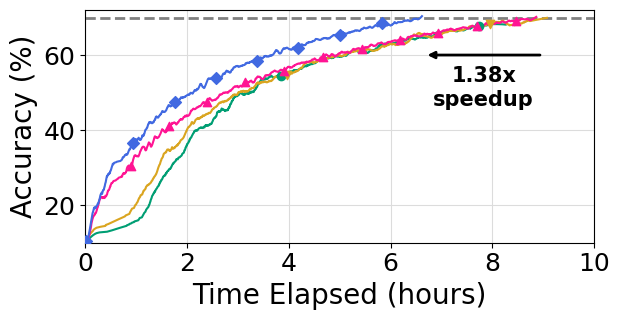

In [89]:
# Plotting the graphs
plot_accuracy_vs_time(
    syn_0_acc_lists, 
    syn_0_strategies,
    filename="cifar_syn0.pdf"
)

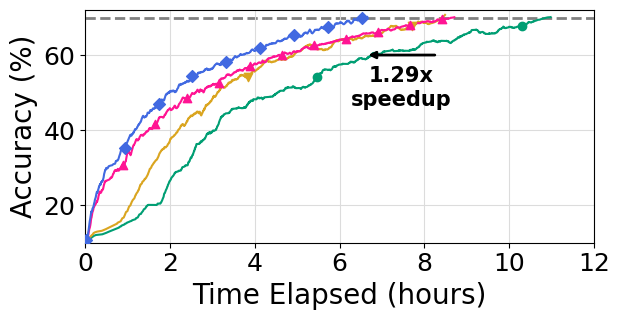

In [90]:
plot_accuracy_vs_time(syn_10_acc_lists, syn_10_strategies, xlim_hours=12, filename="cifar_syn10.pdf")

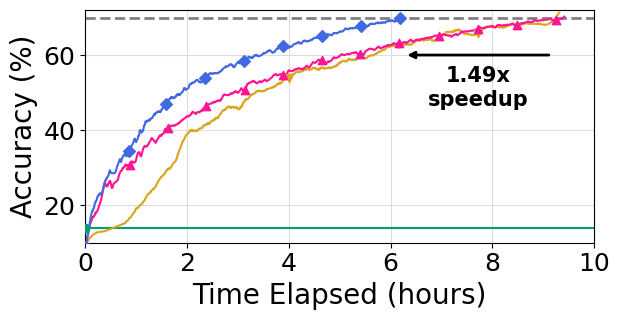

In [91]:
plot_accuracy_vs_time(syn_50_acc_lists, syn_50_strategies, filename="cifar_syn50.pdf")

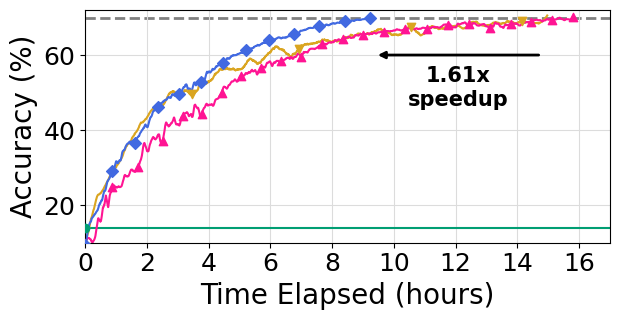

In [92]:
plot_accuracy_vs_time(mobiperf_acc_lists, mobiperf_strategies, xlim_hours=17, filename="cifar_mobiperf.pdf")

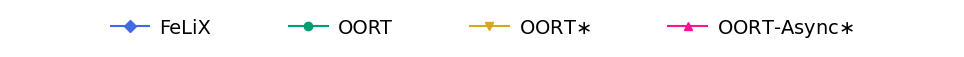

In [93]:
# Strategy display names (optional: tweak these for paper-style names)
strategy_labels = {
    'felix': 'FeLiX',
    'oort': 'OORT',
    'oort_trace': r'OORT$\ast$',
    # 'fedbuff': 'FedBuff',
    'oort_async': r'OORT-Async$\ast$'
}

# Plot dummy lines for legend only
plt.figure(figsize=(9.6, 0.4))
for strategy in strategy_labels:
    plt.plot([], [], linestyle=line_styles[strategy], marker=markers[strategy],
             color=colors[strategy], label=strategy_labels[strategy])

plt.axis('off')
plt.legend(
    fontsize=14, loc="center", frameon=False, ncols=len(strategy_labels),
    handletextpad=0.5, borderaxespad=0, columnspacing=4
)
plt.margins(0, 0)
plt.tight_layout(pad=0)
plt.savefig('/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/plots/paper/legend_strategies.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
# Next we want to capture the communication overhead of each of the
# runs. This is split into 4 messages. Train messages sent from the
# aggregator to trainers, eval messages from aggregator to trainers.
# Weight messages from trainers to aggregator and the eval messages
# from trainers to aggregator. For each log file, return a dict with
# the count of each of these messages. The dict should be of the form
# {agg_train_sent: count, agg_eval_sent: count, agg_weight_recv:
# count, agg_eval_recv: count}. Example messages of each are of the
# form (1) agg_train_sent: "sending weights to <trainer_id> with
# model_version: <ver> for task: train", (2) agg_eval_sent: "sending
# weights to <trainer_id> with model_version: <ver> for task: eval",
# (3) agg_weight_recv: "Received weights from <trainer_id>. It was
# trained on model version <ver>" (4) agg_eval_recv: "received eval
# message"

def parse_communication_overhead(filepath):
    message_counts = {
        'agg_train_sent': 0,
        'agg_eval_sent': 0,
        'agg_weight_recv': 0,
        'agg_eval_recv': 0
    }

    with open(filepath, 'r') as file:
        for line in file:
            if "sending weights" in line and "task: train" in line:
                message_counts['agg_train_sent'] += 1
            elif "sending weights" in line and "task: eval" in line:
                message_counts['agg_eval_sent'] += 1
            elif "Received weights" in line and "trained on model version" in line:
                message_counts['agg_weight_recv'] += 1
            elif "received eval message" in line:
                message_counts['agg_eval_recv'] += 1
                
    # Handle the case for OORT aggregator exclusively. It doesnt count
    # received weight messages.
    if message_counts['agg_weight_recv'] == 0:
        message_counts['agg_weight_recv'] = message_counts['agg_train_sent'] - 13 # because 13 is the concurrency

    return message_counts

In [ ]:
# Populate acc tuples from log files
log_file_dir = "/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/agg_logs"

# Synthetic unavail 0% logs
oort_syn0_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_sheph_14_05_12_52_alpha0.1_cifar_70acc_fedavg_oort_unaware_syn_50.log")
oort_oracular_syn0_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_wash_11_05_02_42_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn0.log")
oort_async_oracular_syn0_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_sheph_11_05_02_42_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn0.log")
felix_syn0_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_sheph_13_05_01_50_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_0.log")

In [96]:
# Synthetic unavail 10% logs
oort_syn10_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_wash_14_05_21_15_alpha0.1_cifar_70acc_fedavg_oort_unaware_syn_20.log")
oort_oracular_syn10_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_wash_11_05_11_49_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn20.log")
oort_async_oracular_syn10_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_jayne_11_05_15_20_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn20.log")
felix_syn10_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_sheph_13_05_08_29_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_20.log")

In [97]:
# Synthetic unavail 50% logs
oort_syn50_comm = None
oort_oracular_syn50_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_wash_11_05_20_20_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn50.log")
oort_async_oracular_syn50_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_sheph_11_05_15_21_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn50.log")
felix_syn50_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_jayne_13_05_01_52_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_50.log")

In [98]:
# Mobiperf logs
oort_mobiperf_comm = None
oort_oracular_mobiperf_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_wash_12_05_05_41_alpha0.1_cifar_70acc_fedavg_oort_oracular_mobiperf.log")
oort_async_oracular_mobiperf_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_jayne_12_05_00_04_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_mobiperf.log")
felix_mobiperf_comm = parse_communication_overhead(
    f"{log_file_dir}/agg_wash_13_05_01_51_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_mobiperf_3st.log")

In [99]:
oort_oracular_mobiperf_comm

{'agg_train_sent': 33229,
 'agg_eval_sent': 0,
 'agg_weight_recv': 33216,
 'agg_eval_recv': 0}

In [100]:
oort_async_oracular_syn0_comm

{'agg_train_sent': 69260,
 'agg_eval_sent': 0,
 'agg_weight_recv': 69230,
 'agg_eval_recv': 0}

In [101]:
felix_syn0_comm

{'agg_train_sent': 47884,
 'agg_eval_sent': 20371,
 'agg_weight_recv': 47855,
 'agg_eval_recv': 20371}

In [102]:
# Write a function to take two primary inputs. The first is a list of
# dictionaries that contain the communication overhead for each of the
# strategies. The second is a list of strategies corresponding to the
# dictionaries. The function should plot the communication overhead as
# a stacked bar graph and also print the total at the top. Each
# train_sent, eval_sent, weight_recv message counts as 1MB while
# eval_recv counts as 0.01MB. The total should be printed in GB upto 1
# decimal place. The base color should be the same as the color of the
# strategy. The function should also take the filename as an argument
# and save the plot with that name.



In [103]:
syn_0_comm_lists = [oort_syn0_comm, oort_oracular_syn0_comm, oort_async_oracular_syn0_comm, felix_syn0_comm]
syn_10_comm_lists = [oort_syn10_comm, oort_oracular_syn10_comm, oort_async_oracular_syn10_comm, felix_syn10_comm]
syn_50_comm_lists = [oort_syn50_comm, oort_oracular_syn50_comm, oort_async_oracular_syn50_comm, felix_syn50_comm]
mobiperf_comm_lists = [oort_mobiperf_comm, oort_oracular_mobiperf_comm, oort_async_oracular_mobiperf_comm, felix_mobiperf_comm]

syn_0_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
syn_10_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
syn_50_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
mobiperf_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']

In [104]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1 - amount) with white.
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    r, g, b, a = mcolors.to_rgba(c)
    return (r + (1 - r) * amount, g + (1 - g) * amount, b + (1 - b) * amount, a)

def plot_communication_overhead(comm_overhead_list, strategies, colors, strategy_labels, ylim_max=120, cross_mark_y_pos=30, filename="temp.pdf"):
    # Initialize components in MB
    train_sent_mb = []
    eval_sent_mb = []
    weight_recv_mb = []
    eval_recv_mb = []
    totals_gb = []
    eval_totals_gb = []
    weight_totals_gb = []

    for comm in comm_overhead_list:
        if comm is None:
            # Use small default MB values to show minimal bar
            train = 50     # e.g., 50MB for train
            eval_s = 0
            weight = 50    # 50MB for weight
            eval_r = 0
            show_as_less_than_1gb = True
        else:
            train = comm['agg_train_sent']
            eval_s = comm['agg_eval_sent']
            weight = comm['agg_weight_recv']
            eval_r = comm['agg_eval_recv'] * 0.01
            show_as_less_than_1gb = False

        train_sent_mb.append(train)
        eval_sent_mb.append(eval_s)
        weight_recv_mb.append(weight)
        eval_recv_mb.append(eval_r)

        total_mb = train + eval_s + weight + eval_r
        eval_total = eval_s + eval_r
        weight_total = train + weight

        totals_gb.append(total_mb / 1024)
        eval_totals_gb.append(eval_total / 1024)
        weight_totals_gb.append(weight_total / 1024)

    bar_positions = np.arange(len(strategies))

    # plt.figure(figsize=(10, 6))

    # Stack bars with color logic
    for i, strategy in enumerate(strategies):
        base_color = colors[strategy]
        eval_color = lighten_color(base_color, 0.5)

        bottom = 0
        train_gb = train_sent_mb[i] / 1024
        plt.bar(bar_positions[i], train_gb, color=base_color, label=None, zorder=2)
        bottom += train_gb

        weight_gb = weight_recv_mb[i] / 1024
        plt.bar(bar_positions[i], weight_gb, bottom=bottom, color=base_color, zorder=2)
        bottom += weight_gb

        eval_sent_gb = eval_sent_mb[i] / 1024
        plt.bar(bar_positions[i], eval_sent_gb, bottom=bottom, color=eval_color, zorder=2)
        bottom += eval_sent_gb

        eval_recv_gb = eval_recv_mb[i] / 1024
        plt.bar(bar_positions[i], eval_recv_gb, bottom=bottom, color=eval_color, zorder=2)
        bottom += eval_recv_gb

        # Total + breakdown annotation
        if comm_overhead_list[i] is None:
            # Print "Run failed" label
            plt.text(
                bar_positions[i], bottom + 3,
                "Stalls\nIndefinitely", ha='center', fontsize=12, fontweight='bold'
            )
            # Print red X above the "<1 GB"
            plt.text(
                bar_positions[i], cross_mark_y_pos,
                "X", ha='center', fontsize=16, fontweight='bold', color='red'
            )
        else:
            plt.text(
                bar_positions[i], bottom + 1,
                f"{totals_gb[i]:.1f} GB", ha='center', fontsize=12, fontweight='bold'
            )
        if comm_overhead_list[i] is not None:
            plt.text(
                bar_positions[i], 5,
                f"(W: {weight_totals_gb[i]:.1f},\nE: {eval_totals_gb[i]:.1f})",
                ha='center', fontsize=12
            )

    # X ticks
    plt.xticks(bar_positions, [strategy_labels[s] for s in strategies], fontsize=12)

    # Y axis in GB
    plt.ylabel("Communication (GB)", fontsize=14)
    plt.yticks(fontsize=12)

    # Legend for message types only
    weight_patch = plt.Rectangle((0, 0), 1, 1, color='gray', label='Weights Msgs')
    eval_patch = plt.Rectangle((0, 0), 1, 1, color='lightgray', label='Eval Msgs')
    plt.legend(
        handles=[weight_patch, eval_patch],
        labels=["Weights Msgs", "Eval Msgs"],
        fontsize=12, loc='upper left', frameon=False
    )
    plt.ylim(0, ylim_max)
    plt.grid(True, color='gainsboro', zorder=1)

    # Title and save
    # plt.title("Communication Overhead by Strategy", fontsize=16)
    plt.tight_layout()
    plt.savefig('/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/plots/paper/'+filename, bbox_inches='tight', pad_inches=0)
    plt.show()

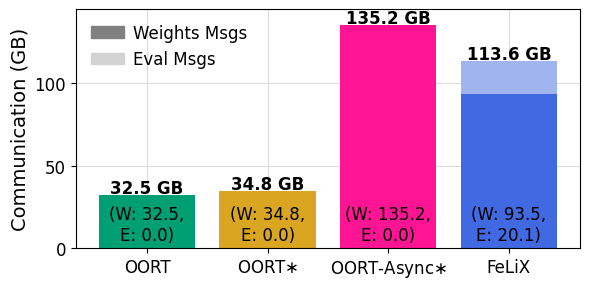

In [105]:
plot_communication_overhead(
    syn_0_comm_lists, 
    syn_0_strategies,
    colors=colors,
    strategy_labels=strategy_labels,
    ylim_max=145,
    filename="cifar_syn0_comm.pdf"
)

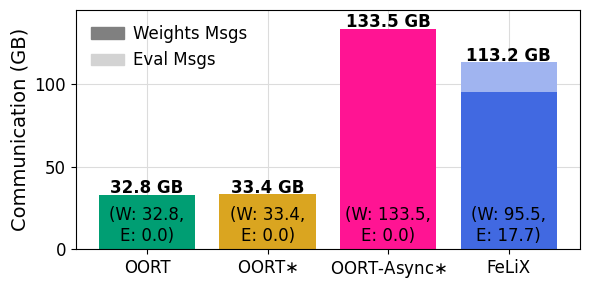

In [106]:
plot_communication_overhead(
    syn_10_comm_lists, 
    syn_10_strategies,
    colors=colors,
    strategy_labels=strategy_labels,
    ylim_max=145,
    filename="cifar_syn10_comm.pdf"
)

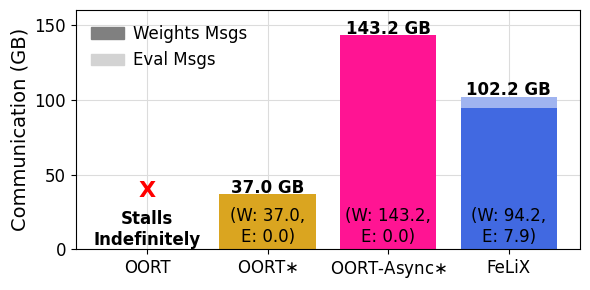

In [107]:
plot_communication_overhead(
    syn_50_comm_lists, 
    syn_50_strategies,
    colors=colors,
    strategy_labels=strategy_labels,
    ylim_max=160,
    cross_mark_y_pos=35,
    filename="cifar_syn50_comm.pdf"
)

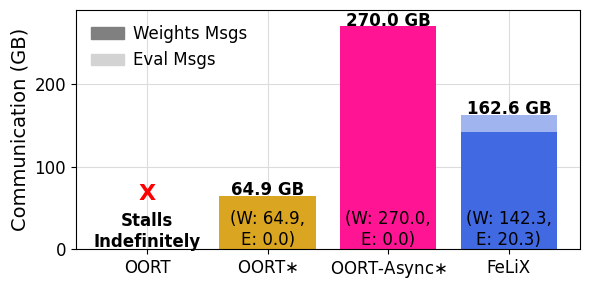

In [108]:
plot_communication_overhead(
    mobiperf_comm_lists, 
    mobiperf_strategies,
    colors=colors,
    strategy_labels=strategy_labels,
    ylim_max=290,
    cross_mark_y_pos=60,
    filename="cifar_mobiperf_comm.pdf"
)

In [ ]:
import ast

# want to analyze the selector decisions for the strategies. First we
# understand the statistical utility of trainers picked by the
# different strategies over a period of the run. For each given log
# file, return a list of tuples where each tuple is of the form
# (time_from_start_seconds, utility). The time_from_start_seconds is
# the time from the start of the run in seconds. The utility is taken
# from the log line: "Train selector stats summary" which actually
# prints out the dict. We are interested in the key called
# "stat_util_last_200" which is also a dict. Within this dict we want
# the "p50" value. The function should take the filename with path of
# the logfile as an argument. The function should return a list of
# tuples.

import ast
from datetime import datetime

def parse_log_file_selector_util(filepath):
    result = []
    base_time = None

    with open(filepath, 'r') as file:
        for line in file:
            if "Train selector stats summary:" in line:
                try:
                    # Split line into timestamp and the dict
                    parts = line.strip().split(" | ")
                    timestamp_str = parts[0]
                    timestamp = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S,%f")

                    # Set base_time on first valid timestamp
                    if base_time is None:
                        base_time = timestamp

                    # Extract dict string after the specific substring
                    dict_str_start = line.index("Train selector stats summary:") + len("Train selector stats summary:")
                    stats_dict_str = line[dict_str_start:].strip()

                    stats_dict = ast.literal_eval(stats_dict_str)
                    util_p50 = stats_dict["stat_util_last_200"]["p50"]

                    # Skip if None
                    if util_p50 is None:
                        continue

                    time_from_start = (timestamp - base_time).total_seconds()
                    result.append((time_from_start, util_p50))

                except (ValueError, IndexError, KeyError, SyntaxError):
                    continue  # Skip malformed lines
    return result

In [187]:
# Populate acc tuples from log files
log_file_dir = "/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/agg_logs"

# Synthetic unavail 0% logs
oort_syn0_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_sheph_14_05_12_52_alpha0.1_cifar_70acc_fedavg_oort_unaware_syn_50.log")
oort_oracular_syn0_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_wash_11_05_02_42_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn0.log")
oort_async_oracular_syn0_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_sheph_11_05_02_42_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn0.log")
felix_syn0_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_sheph_13_05_01_50_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_0.log")

In [188]:
felix_syn0_sel_util

[(8.199, 190.95214849813067),
 (8.313, 190.95214849813067),
 (8.434, 190.95214849813067),
 (8.538, 190.95214849813067),
 (9.062, 190.95214849813067),
 (9.167, 190.95214849813067),
 (13.416, 218.61965531042935),
 (13.53, 218.61965531042935),
 (13.649, 218.61965531042935),
 (13.754, 218.61965531042935),
 (14.289, 218.61965531042935),
 (14.393, 218.61965531042935),
 (18.175, 220.53130835823453),
 (18.289, 220.53130835823453),
 (19.915, 210.5380115854036),
 (20.067, 210.5380115854036),
 (22.771, 223.75911822786642),
 (22.886, 223.75911822786642),
 (23.915, 216.70800226262415),
 (24.031, 216.70800226262415),
 (26.393, 223.75911822786642),
 (26.51, 223.75911822786642),
 (28.555, 222.53302498534185),
 (28.676, 222.53302498534185),
 (28.801, 222.53302498534185),
 (28.906, 222.53302498534185),
 (30.538, 224.01422315856132),
 (30.653, 224.01422315856132),
 (32.956, 224.01422315856132),
 (33.075, 224.01422315856132),
 (34.123, 224.3119712715506),
 (34.238, 224.3119712715506),
 (36.639, 224.141775

In [189]:
# Synthetic unavail 10% logs
oort_syn10_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_wash_14_05_21_15_alpha0.1_cifar_70acc_fedavg_oort_unaware_syn_20.log")
oort_oracular_syn10_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_wash_11_05_11_49_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn20.log")
oort_async_oracular_syn10_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_jayne_11_05_15_20_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn20.log")
felix_syn10_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_sheph_13_05_08_29_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_20.log")

In [190]:
# Synthetic unavail 50% logs
oort_syn50_sel_util = None
oort_oracular_syn50_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_wash_11_05_20_20_alpha0.1_cifar_70acc_fedavg_oort_oracular_syn50.log")
oort_async_oracular_syn50_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_sheph_11_05_15_21_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_syn50.log")
felix_syn50_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_jayne_13_05_01_52_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_syn_50.log")

In [191]:
# Mobiperf logs
oort_mobiperf_sel_util = None
oort_oracular_mobiperf_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_wash_12_05_05_41_alpha0.1_cifar_70acc_fedavg_oort_oracular_mobiperf.log")
oort_async_oracular_mobiperf_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_jayne_12_05_00_04_alpha0.1_cifar_70acc_fedbuff_oortAsync_oracular_mobiperf.log")
felix_mobiperf_sel_util = parse_log_file_selector_util(
    f"{log_file_dir}/agg_wash_13_05_01_51_alpha0.1_cifar_70acc_TierFuse_TierSelect_TierTrack_mobiperf_3st.log")

In [192]:
syn_0_sel_util_lists = [oort_syn0_sel_util, oort_oracular_syn0_sel_util, oort_async_oracular_syn0_sel_util, felix_syn0_sel_util]
syn_10_sel_util_lists = [oort_syn10_sel_util, oort_oracular_syn10_sel_util, oort_async_oracular_syn10_sel_util, felix_syn10_sel_util]
syn_50_sel_util_lists = [oort_syn50_sel_util, oort_oracular_syn50_sel_util, oort_async_oracular_syn50_sel_util, felix_syn50_sel_util]
mobiperf_sel_util_lists = [oort_mobiperf_sel_util, oort_oracular_mobiperf_sel_util, oort_async_oracular_mobiperf_sel_util, felix_mobiperf_sel_util]

syn_0_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
syn_10_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
syn_50_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']
mobiperf_strategies = ['oort', 'oort_trace', 'oort_async', 'felix']

In [193]:
# Write a function to plot selector utility of multiple baselines over
# time. The function should take two main inputs. The first is a list of
# lists that contain the timestamp and utility tuples. The second is a
# list of strategies corresponding to the lists. The function should
# plot the selector utility vs time graph for each strategy. The
# function should also take the filename as an argument and save the
# plot with that name. The function should also take the xlim_hours
# argument to set the x-axis limits in hours.

def plot_selector_util_vs_time(
    data_lists,
    strategies,
    filename="selector_util.pdf",
    xlim_hours=10,
    smooth=True,                # New: enable smoothing
    smoothing_method='savgol',   # 'savgol' or 'moving_average'
    window_size=101,
    polyorder=2
):
    for data, strategy in zip(data_lists, strategies):
        if data is None or len(data) == 0:
            continue
        times, utils = zip(*data)
        times = np.array(times)
        utils = np.array(utils)

        if smooth and len(utils) > 2:
            if smoothing_method == 'moving_average':
                if window_size > len(utils):
                    window_size = len(utils)
                smoothed_utils = np.convolve(utils, np.ones(window_size) / window_size, mode='valid')
                smoothed_times = times[:len(smoothed_utils)]
            elif smoothing_method == 'savgol':
                if window_size % 2 == 0:
                    window_size += 1
                if window_size > len(utils):
                    window_size = len(utils) if len(utils) % 2 == 1 else len(utils) - 1
                smoothed_utils = savgol_filter(utils, window_size, polyorder)
                smoothed_times = times
            else:
                raise ValueError("Invalid smoothing method. Use 'moving_average' or 'savgol'.")
        else:
            smoothed_utils = utils
            smoothed_times = times

        plt.plot(
            smoothed_times,
            smoothed_utils,
            label=strategy_labels.get(strategy, strategy),
            color=colors[strategy],
            linestyle=line_styles[strategy],
            marker=markers[strategy],
            markevery=max(len(smoothed_times)//10, 1),
            zorder=2
        )

    plt.xlabel("Time Elapsed (seconds)")
    plt.ylabel("Sel. Stat. Util. (p50)")
    plt.xlim(0, xlim_hours * 3600)
    plt.grid(True, color='gainsboro', zorder=1)
    plt.tight_layout()
    plt.savefig('/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/plots/paper/' + filename, bbox_inches='tight', pad_inches=0)
    plt.show()

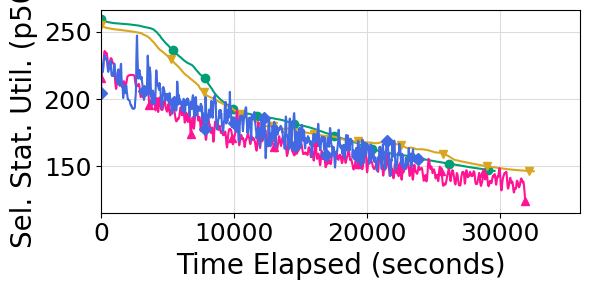

In [194]:
plot_selector_util_vs_time(
    syn_0_sel_util_lists,
    syn_0_strategies,
    filename="cifar_syn0_selector_util.pdf",
    xlim_hours=10
)

In [195]:
def plot_selector_util_cdf(
    data_lists,
    strategies,
    filename="selector_util_cdf.pdf"
):
    for data, strategy in zip(data_lists, strategies):
        if data is None or len(data) == 0:
            continue

        _, utils = zip(*data)
        utils = np.array(utils)
        utils = utils[~np.isnan(utils)]  # remove NaNs if any

        sorted_utils = np.sort(utils)
        cdf = np.linspace(0, 1, len(sorted_utils))

        plt.plot(
            sorted_utils,
            cdf,
            label=strategy_labels.get(strategy, strategy),
            color=colors[strategy],
            linestyle=line_styles[strategy],
            marker=markers[strategy],
            markevery=max(len(cdf)//10, 1),
            zorder=2
        )

    plt.xlabel("Selector Statistical Utility (p50)")
    plt.ylabel("CDF")
    plt.grid(True, color='gainsboro', zorder=1)
    # plt.legend()
    plt.tight_layout()
    plt.savefig(
        '/home/dgarg39/flame/lib/python/examples/async_cifar10/eurosys26_expts/plots/paper/' + filename,
        bbox_inches='tight', pad_inches=0
    )
    plt.show()

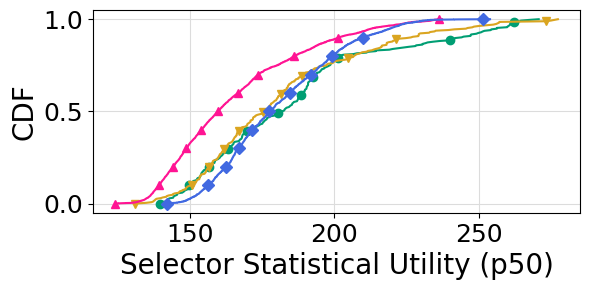

In [196]:
plot_selector_util_cdf(
    syn_0_sel_util_lists,
    syn_0_strategies,
    filename="cifar_syn0_selector_util_cdf.pdf",
)